# 21.11.2023

### Importujemy potrzebne nam biblioteki
___

In [1]:
import keras
import tensorflow as tf
from keras import models
from keras import layers
import numpy as np
import pandas as pd
import datetime
import keras_tuner as kt

Using TensorFlow backend


### Budowanie modelu sieci konwolucyjnej
___

In [2]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',name='conv1',input_shape=(28,28,1), padding = 'valid'))
model.add(layers.MaxPooling2D((2, 2), name='maxpool1'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', name='conv2'))
model.add(layers.MaxPooling2D((2, 2), name='maxpool2'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', name='conv3'))

model.summary()

model.add(layers.Flatten(name='Flatten'))
model.add(layers.Dense(64, activation='relu', name='Dense1'))
model.add(layers.Dense(23, activation= 'softmax', name='Dense2'))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 26, 26, 32)        320       
                                                                 
 maxpool1 (MaxPooling2D)     (None, 13, 13, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 11, 11, 64)        18496     
                                                                 
 maxpool2 (MaxPooling2D)     (None, 5, 5, 64)          0         
                                                                 
 conv3 (Conv2D)              (None, 3, 3, 64)          36928     
                                                                 
Total params: 55744 (217.75 KB)
Trainable params: 55744 (217.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Dane ze zbioru Sign Language MNIST
___
Zbior zawiera obrazy 28x28 w skali szarosci

Kazdy obraz przedstawia dlog prezentujaca litere alfabetu migowego

Warto nadmienic ze w zbiorze tym nie znajdziemy litery J poniewaz do wykonania tej litery wymagany jest dodatkowy ruch dlonia

In [3]:
data=pd.read_csv('sign_mnist_train.csv')
data_test = data=pd.read_csv('sign_mnist_test.csv')

In [4]:
print(data.shape)
print(data_test.shape)

(7172, 785)
(7172, 785)


Ponizej widzimy ze w liscie labeli nie znajduje sie nr 9

In [5]:
print(sorted(data.label.unique())) #ponizej widac brak klasy nr 9
print(sorted(data_test.label.unique())) #ponizej widac brak klasy nr 9

[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


Aby pozbyc sie problemu brakujacej klasy kazdy label wiekszy od 9 zmniejszamy o 1

In [6]:
def adjust_class_labels(label):
   
    if label >= 10:
        label -= 1
    
    return label

# Adjusting the class labels (training data)
data["label"] = data["label"].apply(adjust_class_labels)
data_test["label"] = data_test["label"].apply(adjust_class_labels)

In [7]:
print(sorted(data.label.unique()))
print(sorted(data_test.label.unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


Rysujemy dwa pierwsze obrazy zeby upewnic sie ze dane zostaly wczytane prawidolowo

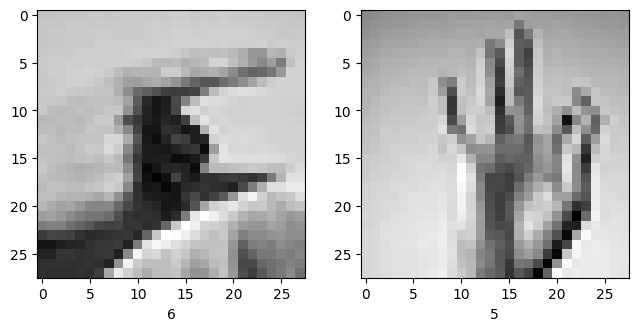

In [8]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 

images=data.drop('label',axis=1).values

plt.figure(figsize=(16,16))
for i in range(2): 
    img=images[i].reshape(28,28)
    fig = plt.subplot(4,4,i+1)
    plt.xlabel(data['label'][i])
    plt.imshow(img, cmap='gray')

Z danych testowych pozbywamy sie etykiet i etykiety te przypisujemy do oddzielnego zbioru przeznaczonego na etykiety wlasnie

Nastepnie ustalamy odpowiedni wymiar danych i przeskalowujemy nasze dane na wartosci z przedzialu [0,1]

Na koniec zakodywujemy etykiety za pomocą kategorii

In [9]:
x_train = data.drop('label',axis=1)
x_test = data_test.drop('label', axis=1)

y_train = data.label
y_test = data_test.label

x_train = x_train.values.reshape(-1,28,28,1)
x_train = x_train/255

x_test = x_test.values.reshape(-1,28,28,1)
x_test = x_test/255

y_train = keras.utils.to_categorical(y_train) 
y_test = keras.utils.to_categorical(y_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(7172, 28, 28, 1)
(7172, 23)
(7172, 28, 28, 1)
(7172, 23)


Jesli istnieje folder z logami naszego modelu to pozbywamy sie go zeby dane nowego modelu mozna bylo pozniej uzyc w tensorboardzie 

In [10]:
%rm -rf ./logs/fit/first/

Tworzymy callback za pomoca ktorego bedziemy mogli potem otrzymac informacje o procesie uczenia modelu w tensorboardzie

In [11]:
log_dir = "logs/fit/first/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=False)

Kompilujemy i fitujemy model z wczesniej zdefiniowanym callbackiem

In [12]:
model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history=model.fit(x_train, y_train, epochs=15 ,validation_split=0.3, callbacks=[tensorboard_callback])

Epoch 1/15
157/157 [==============================] - 2s 10ms/step - loss: 3.1019 - accuracy: 0.0821 - val_loss: 3.0577 - val_accuracy: 0.1004
Epoch 2/15
157/157 [==============================] - 1s 10ms/step - loss: 3.0262 - accuracy: 0.1361 - val_loss: 2.9608 - val_accuracy: 0.1808
Epoch 3/15
157/157 [==============================] - 2s 10ms/step - loss: 2.8865 - accuracy: 0.1849 - val_loss: 2.7643 - val_accuracy: 0.2063
Epoch 4/15
157/157 [==============================] - 2s 10ms/step - loss: 2.6340 - accuracy: 0.2534 - val_loss: 2.4631 - val_accuracy: 0.2844
Epoch 5/15
157/157 [==============================] - 2s 10ms/step - loss: 2.3489 - accuracy: 0.3175 - val_loss: 2.2044 - val_accuracy: 0.3666
Epoch 6/15
157/157 [==============================] - 2s 11ms/step - loss: 2.1005 - accuracy: 0.3855 - val_loss: 1.9670 - val_accuracy: 0.4173
Epoch 7/15
157/157 [==============================] - 2s 11ms/step - loss: 1.8903 - accuracy: 0.4502 - val_loss: 1.7880 - val_accuracy: 0.4670

Sprawdzamy jak model da sobie rade na danych testowych

In [13]:
test_loss, test_accuracy = model.evaluate(x_test,y_test)
print(f"Dokladnosc modelu na danych testowych to: {test_accuracy} ze strata rowna {test_loss}")


225/225 [==============================] - 1s 3ms/step - loss: 0.7783 - accuracy: 0.7814
Dokladnosc modelu na danych testowych to: 0.7813720107078552 ze strata rowna 0.7782968878746033


Aby wykorzystac mozliwosci ktore gwarantuje nam TensorBoard nalezy uzyc nastepujacej komendy w konsoli

```sh
tensorboard --logdir logs/fit/first/
```


In [14]:
%tensorboard --logdir logs/fit/first/ --port 6006

UsageError: Line magic function `%tensorboard` not found.


# Informacje z tensorboard
* Model uczy sie
* Model powinien uczyc sie wieksza liczbe epok poniewaz:
    * Dokladnosc rosnie
    * Strata maleje


# 28.11.2023

## Tuner

W ponizszej implementacji funkcji build_model do tunera modelu konwolucyjnej sieci neuronowej tunujemy nastepujace hiperparametry:
* Liczbe warst Conv2D i co za tym idzie rowniez liczbe warstw Pooling
* W warstwie Conv2D tunujemy:
    * Liczbe filtrow z przedzialu [32,256]
    * Wielkosc kernela przechodzacego przez obraz z przedzialu [3,5]
* Rodzaj warstwy pooling wybieramy pomiedzy:
    * MaxPooling - w tym przypadku filtr bierze wartosc maksymalna w danym kernelu
    * AvgPooling - w tym przypadku filtr bierze wartosc srednia w danym kernelu
* Liczbe warstw lub wartstwy gestej wystepujacych po warstwie splaszczajacej w tym przypadku wybieramy:
    * Liczbe warstw gestych
    * Liczbe neuronow w kazdej warstwie
* W warstwie Dropout tunujemy dropout rate, aby ograniczyc przetrenowanie
* Wspolczynnik uczenia
* Optimizer w ktorym wybieramy pomiedzy:
    * Stochastycznym spadkiem wzdluz gradientu, SGD
    * Adam


In [15]:
def build_model(hp):
    model = keras.Sequential()
    
    for i in range(hp.Int('num_conv_layers', min_value=1, max_value=4)): #tunujemy liczbe warstw Conv2D
        model.add(layers.Conv2D(
            filters=hp.Int(f'{i}_conv_filters', min_value=32, max_value=256, step=32), #tunowanie liczby filtrow
            kernel_size=hp.Choice(f'{i}_conv_kernel_size', values=[3, 5]), #tunowanie wielkosci kernela
            activation='relu',
            input_shape=(28, 28, 1),
            name=f'{i}_conv_layer' 
        ))
        
        pooling = hp.Choice(f'{i}_pooling', values=['max','avg']) #tunowanie wyboru warstwy pooling 
        
        if pooling == 'max':
            model.add(layers.MaxPooling2D(pool_size=(2, 2),name=f'{i}_max_pooling')) 
        else:
            model.add(layers.AveragePooling2D(pool_size=(2, 2), name=f'{i}_avg_pooling'))

    model.add(layers.Flatten(name='flatten')) #splaszczanie

    for j in range(hp.Int('num_dense_layers', min_value=1, max_value=3)): #tunowanie liczby warstw gestych
        model.add(layers.Dense(
            units=hp.Int(f'{j}_n_neurons', min_value=32, max_value=512, step=32), #tunowanie liczby neuronow w warstwie gestej
            activation='relu',
            name=f'{j}_dence_layer'
            ))
        
        model.add(layers.Dropout(rate=hp.Float(f'{j}_dropout', min_value=0.0, max_value=0.5, step=0.1))) #tunowanie dropout rate

    model.add(layers.Dense(23, activation='softmax',name='output_layer')) 

    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log") #tunowanie learning rate
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"]) #tunowanie optimizera
    
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
        
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',  
                  metrics=['accuracy'])

    return model

Definiujemy nastepujace callbacki:
* tensorboard_callback - aby mozliwe bylo uzywanie tensorboard_callback
* early_stopping_cb - aby w momencie kiedy model przestaje sie uczyc. Uczenie sie zatrzymywalo

In [16]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=8,restore_best_weights=True)
log_dir = "logs/fit/tuner/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=False)

Definiujemy tuner hyperband

In [17]:
hyperband_tuner = kt.Hyperband(
    build_model, objective="val_accuracy", seed=33,
    max_epochs=10, factor=3, hyperband_iterations=4,
    overwrite=True, directory="sign_mnist", project_name="hyperband")

Ponownie pozbywamy sie logow poprzedniego modelu zeby tensorboard mial miejsce z ktorego bedzie mogl pobierac informacje o modelu

In [18]:
%rm -rf ./logs/fit/tuner/

Tunujemy hiperparametry z wczesniej zadeklarowanymi callbackami

In [19]:
hyperband_tuner.search(x_train, y_train, epochs=20, validation_split=0.2, callbacks=[early_stopping_cb,tensorboard_callback])

Trial 95 Complete [00h 02m 00s]
val_accuracy: 0.05714285746216774

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 23m 39s


Pobieramy najlepsze 2 wyniki z ktorych pobieramy najlepszy model wraz z jego parametrami

In [20]:
two_best_model_hyperband = hyperband_tuner.get_best_models(num_models=2)
best_model_hyperband = two_best_model_hyperband[0]
params_hyperband = hyperband_tuner.get_best_hyperparameters(num_trials=5)
print(f"Parametry hyperband{params_hyperband[0].values}")

Parametry hyperband{'num_conv_layers': 2, '0_conv_filters': 256, '0_conv_kernel_size': 3, '0_pooling': 'max', 'num_dense_layers': 2, '0_n_neurons': 64, '0_dropout': 0.0, 'learning_rate': 0.00304325168554751, 'optimizer': 'adam', '1_conv_filters': 256, '1_conv_kernel_size': 3, '1_pooling': 'max', '2_conv_filters': 96, '2_conv_kernel_size': 5, '2_pooling': 'max', '1_n_neurons': 192, '1_dropout': 0.30000000000000004, '2_n_neurons': 448, '2_dropout': 0.0, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0012'}


Aby wykorzystac mozliwosci ktore gwarantuje nam TensorBoard nalezy uzyc nastepujacej komendy w konsoli

```sh
tensorboard --logdir logs/fit/second/
```

In [21]:
%tensorboard --logdir logs/fit/tuner/ --port 6006

UsageError: Line magic function `%tensorboard` not found.


Dzieki powyzszej komendzie mozemy zobaczyc jak radzily sobie wszystkie tunowane modele,
odrazu widac ktore z nich radzily sobie slabo, ktore przecietnie, i jakie okazaly sie bardzo dobre w tym przypadku.

Przygotowujemy sobie miejsce do wstawienia informacji o fitowaniu najlepszego modelu

In [22]:
%rm -rf ./logs/fit/best/

In [23]:
log_dir = "logs/fit/best/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=False)

Fitujemy nasz wytunowany model na danych treningowych wraz z callbackami

In [24]:
best_model_hyperband.fit(x_train, y_train, validation_split=0.2, epochs=5,callbacks=[tensorboard_callback,early_stopping_cb])

Epoch 1/5
180/180 [==============================] - 11s 63ms/step - loss: 0.0056 - accuracy: 0.9988 - val_loss: 2.7938e-04 - val_accuracy: 1.0000
Epoch 2/5
180/180 [==============================] - 11s 61ms/step - loss: 0.0021 - accuracy: 0.9998 - val_loss: 9.0082e-05 - val_accuracy: 1.0000
Epoch 3/5
180/180 [==============================] - 11s 61ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 7.9733e-05 - val_accuracy: 1.0000
Epoch 4/5
180/180 [==============================] - 11s 62ms/step - loss: 0.0631 - accuracy: 0.9805 - val_loss: 0.0505 - val_accuracy: 0.9798
Epoch 5/5
180/180 [==============================] - 12s 65ms/step - loss: 0.0286 - accuracy: 0.9897 - val_loss: 0.0017 - val_accuracy: 1.0000


Ewaluujemy nasz model na danych testowych i wypisujemy dokladnosc i strate

In [25]:
test_loss, test_accuracy = best_model_hyperband.evaluate(x_test,y_test)
print(f"Model po tunowaniu na danych testowych otrzymuje dokladnosci na poziomie: {test_accuracy}.\nZ strata na poziomie: {test_loss}")

225/225 [==============================] - 4s 17ms/step - loss: 0.0017 - accuracy: 1.0000
Model po tunowaniu na danych testowych otrzymuje dokladnosci na poziomie: 1.0.
Z strata na poziomie: 0.001710424548946321


Na koniec sprawdzamy jak sprawdzil sie najlepszy model

```sh
tensorboard --logdir logs/fit/best/
```


In [26]:
%tensorboard --logdir logs/fit/best/ --port 6006

UsageError: Line magic function `%tensorboard` not found.


Tutaj widac ze model dziala wybitnie na danych. Dokladnosc niemal odrazu osiaga 100% przy niewielkiej stracie.

Widac jak wiele zyskujemy uzywajac tunera. Ktory utworzyl model ktory w 2 epoki osiaga wynik 100% kiedy model skladany recznie po 15 epokach moze sie pochwalic 78% dokladnoscia.



Jesli proces nie chce sie uruchomic to warto sprawdzic czy poprzedni nie dziala w tle.

In [27]:
%lsof -i :6006

UsageError: Line magic function `%lsof` not found.
